In [ ]:
!pip install torch_geometric torch_sparse torch_scatter torch_cluster torch_spline_conv h5py -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                          

In [1]:
!pip install h5py

In [13]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt


In [14]:
# ============================================================================
# 2.1) Cargar final_tensor_temporal (X)
# ============================================================================
with h5py.File("data_temporal.h5", "r") as h5_file:
    num_nodes = len(h5_file.keys())  # p.ej. 146
    node_tensors = []
    for key in range(num_nodes):
        data = h5_file[str(key)][()]  # (410, 81)
        time_steps = data.shape[0]
        sliding_windows = []
        for t in range(4, time_steps):
            window = data[t-4:t]  # (4, 81)
            sliding_windows.append(window)
        node_tensor = np.stack(sliding_windows)  # (time_steps-4, 4, 81)
        node_tensors.append(node_tensor)
    final_tensor_temporal = np.stack(node_tensors, axis=1)  # (406, num_nodes, 4, 81)

print("Shape de X (final_tensor_temporal):", final_tensor_temporal.shape)

# ============================================================================
# 2.2) Cargar adjacency_tensor (A)
# ============================================================================
with h5py.File("matrices_adyacencia.h5", "r") as h5_file:
    time_keys = sorted(h5_file.keys(), key=lambda x: int(x))
    num_time_steps = len(time_keys)  # p.ej. 410
    num_windows = num_time_steps - 4
    num_nodes_check = h5_file[time_keys[0]].shape[0]
    adjacency_tensor = np.zeros((num_windows, 4, num_nodes_check, num_nodes_check))

    for window_idx, t in enumerate(range(4, num_time_steps)):
        window = []
        for i in range(4):
            time_key = time_keys[t - 4 + i]
            adj_mat = h5_file[time_key][()]
            window.append(adj_mat)
        adjacency_tensor[window_idx] = np.stack(window)

print("Shape de A (adjacency_tensor):", adjacency_tensor.shape)

# ============================================================================
# 2.3) Cargar final_output_tensor (Y)
# ============================================================================
with h5py.File("data_temporal.h5", "r") as h5_file:
    num_nodes = len(h5_file.keys())
    output_tensors = []
    for key in range(num_nodes):
        data = h5_file[str(key)][()]  # (410, 81)
        time_steps = data.shape[0]
        targets = []
        for t in range(4, time_steps):
            target = data[t]  # (81,)
            targets.append(target)
        node_targets = np.array(targets).reshape(-1, 1, 81)  # (406,1,81)
        output_tensors.append(node_targets)
    final_output_tensor = np.stack(output_tensors, axis=1)  # (406, num_nodes, 1, 81)

print("Shape de Y (final_output_tensor):", final_output_tensor.shape)


Shape de X (final_tensor_temporal): (406, 146, 4, 81)
Shape de A (adjacency_tensor): (406, 4, 146, 146)
Shape de Y (final_output_tensor): (406, 146, 1, 81)


In [15]:
# ============================================================================
# 3.1) Dataset
# ============================================================================
class SpatioTemporalDataset(Dataset):
    def __init__(self, input_data, adjacency_data, output_data):
        # input_data:    (num_samples, num_nodes, 4, 81)
        # adjacency_data:(num_samples, 4, num_nodes, num_nodes)
        # output_data:   (num_samples, num_nodes, 1, 81)
        self.input_data = torch.tensor(input_data, dtype=torch.float32)
        self.adjacency_data = torch.tensor(adjacency_data, dtype=torch.float32)
        self.output_data = torch.tensor(output_data, dtype=torch.float32)

    def __len__(self):
        return self.input_data.shape[0]

    def __getitem__(self, idx):
        return (
            self.input_data[idx],      # (num_nodes, 4, 81)
            self.adjacency_data[idx],  # (4, num_nodes, num_nodes)
            self.output_data[idx]      # (num_nodes, 1, 81)
        )

dataset = SpatioTemporalDataset(final_tensor_temporal, adjacency_tensor, final_output_tensor)

# ============================================================================
# 3.2) División temporal (80/10/10)
# ============================================================================
num_samples = len(dataset)  # p.ej. 406
train_size = int(0.8 * num_samples)
val_size   = int(0.1 * num_samples)
test_size  = num_samples - train_size - val_size

train_indices = list(range(0, train_size))
val_indices   = list(range(train_size, train_size + val_size))
test_indices  = list(range(train_size + val_size, num_samples))

train_subset = Subset(dataset, train_indices)
val_subset   = Subset(dataset, val_indices)
test_subset  = Subset(dataset, test_indices)

# ============================================================================
# 3.3) Cálculo de min y max en train
# ============================================================================
train_input = dataset.input_data[train_indices]   # (train_size, num_nodes, 4, 81)
train_output= dataset.output_data[train_indices]  # (train_size, num_nodes, 1, 81)
train_adj   = dataset.adjacency_data[train_indices]# (train_size, 4, num_nodes, num_nodes)

# Min y max de features (81)
input_min = torch.amin(train_input, dim=(0,1,2), keepdim=False)  # (81,)
input_max = torch.amax(train_input, dim=(0,1,2), keepdim=False)  # (81,)
output_min= torch.amin(train_output,dim=(0,1,2), keepdim=False)  # (81,)
output_max= torch.amax(train_output,dim=(0,1,2), keepdim=False)  # (81,)

# Para la adyacencia, min y max global
adj_min = torch.amin(train_adj)
adj_max = torch.amax(train_adj)

# ============================================================================
# 3.4) Dataset normalizado
# ============================================================================
class NormalizedDataset(Dataset):
    def __init__(self, subset, input_min, input_max, output_min, output_max, adj_min, adj_max):
        self.subset = subset
        self.input_min = input_min
        self.input_max = input_max
        self.output_min = output_min
        self.output_max = output_max
        self.adj_min = adj_min
        self.adj_max = adj_max

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x, A, y = self.subset[idx]
        # x: (num_nodes, 4, 81)
        # Normalizar en la última dimensión (81)
        x_norm = (x - self.input_min) / (self.input_max - self.input_min + 1e-8)
        y_norm = (y - self.output_min) / (self.output_max - self.output_min + 1e-8)
        # A: escalar a [-1,1]
        A_norm = 2 * ((A - self.adj_min) / (self.adj_max - self.adj_min + 1e-8)) - 1
        return x_norm, A_norm, y_norm

train_dataset = NormalizedDataset(train_subset, input_min, input_max,
                                  output_min, output_max, adj_min, adj_max)
val_dataset   = NormalizedDataset(val_subset,   input_min, input_max,
                                  output_min, output_max, adj_min, adj_max)
test_dataset  = NormalizedDataset(test_subset,  input_min, input_max,
                                  output_min, output_max, adj_min, adj_max)

# ============================================================================
# 3.5) DataLoaders
# ============================================================================
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:  ", len(val_dataset))
print("Test samples: ", len(test_dataset))


Train samples: 324
Val samples:   40
Test samples:  42


In [21]:
class TemporalConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, dilation=1):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(1, kernel_size),
            dilation=(1, dilation),
            padding=(0, 0)  # sin padding
        )

    def forward(self, x):
        # x: (B, in_channels, N, T)
        return self.conv(x)  # (B, out_channels, N, T')



In [17]:
class GraphConvLayer(nn.Module):
    """
    Multiplica X por la matriz de adyacencia (dinámica) para capturar
    dependencias espaciales.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mlp = nn.Linear(in_channels, out_channels)

    def forward(self, x, A):
        """
        x: (batch, num_nodes, in_channels)  # estado de los nodos
        A: (batch, num_nodes, num_nodes)    # adyacencia
        """
        # Paso 1: Agregación espacial: X' = A * X
        #   (B, N, N) x (B, N, in_channels) => (B, N, in_channels)
        # Haremos: X_spatial = torch.einsum('bij,bjf->bif', A, x)
        x_spatial = torch.einsum('bij,bjf->bif', A, x)

        # Paso 2: Proyección MLP: (b, n, in_channels) -> (b, n, out_channels)
        out = self.mlp(x_spatial)
        return out


In [18]:
class GWNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_nodes, dilation=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_nodes = num_nodes

        # Capa temporal dilatada
        self.tconv = TemporalConvLayer(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=2,
            dilation=dilation
        )
        # Proyección para GC
        self.gc_in = nn.Linear(out_channels, out_channels)

        # Capa de Convolución en Grafos
        self.gconv = GraphConvLayer(
            in_channels=out_channels,
            out_channels=out_channels
        )

        # Proyección final
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=(1,1))

    def forward(self, x, A):
        """
        x: (batch, in_channels, num_nodes, T)
        A: (batch, T, num_nodes, num_nodes) -> adyacencia para cada paso
        """
        B, C, N, T = x.shape

        # 1) Convolución temporal
        x_t = self.tconv(x)  # (B, out_channels, N, T')
        # T' ~ T - dilation*(kernel_size-1)

        # 2) Reordenar para la convolución en grafos
        #    x_t: (B, out_channels, N, T') => tomamos la última dimensión temporal
        #    para la "instantánea" actual (o un pooling). Aquí haremos un "último" para simplificar
        x_t_last = x_t[:, :, :, -1]  # (B, out_channels, N)
        # Reordenamos a (B, N, out_channels)
        x_t_last = x_t_last.permute(0, 2, 1)

        # 3) Proyección lineal
        x_proj = self.gc_in(x_t_last)  # (B, N, out_channels)

        # 4) Convolución en grafos
        #    Escogemos la última matriz de adyacencia A[:, -1, :, :]
        #    o un promedio de A en el tiempo. Aquí, usaremos la última
        A_last = A[:, -1, :, :]  # (B, N, N)
        x_spatial = self.gconv(x_proj, A_last)  # (B, N, out_channels)

        # 5) Reconvertir a (B, out_channels, N, 1) para concatenar
        x_spatial = x_spatial.permute(0, 2, 1).unsqueeze(-1)

        # 6) Skip connection
        #    Ajustamos x para tener la misma shape (B, out_channels, N, T') => tomamos T' = x_t.shape[3]
        x_res = self.residual(x[..., -x_t.shape[-1]:])  # recortamos el tiempo
        out = x_spatial + x_t + x_res  # broadcast en la dimensión final

        return out


In [19]:
class GraphWaveNet(nn.Module):
    def __init__(self,
                 num_nodes=146,
                 in_features=81,
                 out_features=81,
                 hidden_channels=32,
                 layers=2):
        """
        num_nodes: cantidad de nodos
        in_features: dimensión de entrada (81)
        out_features: dimensión de salida (81)
        hidden_channels: canales internos en TConv y GConv
        layers: cuántos bloques de GraphWaveNet
        """
        super().__init__()
        self.num_nodes = num_nodes
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_channels = hidden_channels
        self.layers = layers

        # Proyección inicial: (in_features) -> hidden_channels
        self.input_proj = nn.Linear(in_features, hidden_channels)

        # Lista de bloques
        self.blocks = nn.ModuleList()
        dilations = [1, 2, 4, 8]  # Ejemplo de dilaciones
        # Usaremos 'layers' bloques, eligiendo la dilación cíclicamente
        for i in range(layers):
            d = dilations[i % len(dilations)]
            block = GWNetBlock(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                num_nodes=num_nodes,
                dilation=d
            )
            self.blocks.append(block)

        # Proyección final
        self.output_fc = nn.Linear(hidden_channels, out_features)

    def forward(self, x, A):
        """
        x: (batch, num_nodes, T, in_features)
        A: (batch, T, num_nodes, num_nodes)
        Retorna: (batch, num_nodes, 1, out_features)
        """
        B, N, T, F_in = x.shape

        # 1) Reordenar x a (B, F_in, N, T) para conv2d
        x = x.permute(0, 3, 1, 2)  # (B, in_features, num_nodes, T)

        # 2) Proyección inicial a hidden_channels
        #    Para ello, mapeamos la dimensión 'in_features' a 'hidden_channels'
        #    pero es más fácil si reordenamos a (B*N, T, in_features)
        #    y luego re-ensamblamos
        x_reshape = x.permute(0, 2, 3, 1).reshape(B*N*T, F_in)
        x_proj = self.input_proj(x_reshape)  # (B*N*T, hidden_channels)
        x_proj = x_proj.view(B, N, T, self.hidden_channels)
        x_proj = x_proj.permute(0, 3, 1, 2)  # (B, hidden_channels, N, T)
        x = x_proj

        # 3) Pasar por los bloques GraphWaveNet
        for block in self.blocks:
            x = block(x, A)  # (B, hidden_channels, N, T')

        # 4) Tomar la última representación => (B, hidden_channels, N)
        #    y proyectar a out_features
        x_last = x[..., -1]  # (B, hidden_channels, N)
        x_last = x_last.permute(0, 2, 1)  # (B, N, hidden_channels)

        out = self.output_fc(x_last)      # (B, N, out_features)

        # 5) Reordenar a (B, N, 1, out_features)
        out = out.unsqueeze(2)
        return out


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

model = GraphWaveNet(
    num_nodes=146,      # Ajusta si tienes distinto num_nodes
    in_features=81,     # 81 features de entrada
    out_features=81,    # 81 features de salida
    hidden_channels=32, # Prueba con 32, 64, etc.
    layers=2            # Número de bloques
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

num_epochs = 500
best_val_loss = float("inf")
best_model_state_dict = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for x_batch, A_batch, y_batch in train_loader:
        x_batch, A_batch, y_batch = x_batch.to(device), A_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(x_batch, A_batch)  # (B, N, 1, 81)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, A_val, y_val in val_loader:
            x_val, A_val, y_val = x_val.to(device), A_val.to(device), y_val.to(device)
            y_pred_val = model(x_val, A_val)
            val_loss += criterion(y_pred_val, y_val).item()

    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()

if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "Mejor_modelo_graphwavenet.pth")
    print("Se guardó el mejor modelo con val_loss =", best_val_loss)


Usando dispositivo: cpu
Epoch [1/500] - Train Loss: 0.1501 - Val Loss: 0.0226
Epoch [2/500] - Train Loss: 0.0135 - Val Loss: 0.0103
Epoch [3/500] - Train Loss: 0.0085 - Val Loss: 0.0079
Epoch [4/500] - Train Loss: 0.0065 - Val Loss: 0.0062
Epoch [5/500] - Train Loss: 0.0051 - Val Loss: 0.0052
Epoch [6/500] - Train Loss: 0.0044 - Val Loss: 0.0047
Epoch [7/500] - Train Loss: 0.0041 - Val Loss: 0.0045
Epoch [8/500] - Train Loss: 0.0040 - Val Loss: 0.0045
Epoch [9/500] - Train Loss: 0.0040 - Val Loss: 0.0044
Epoch [10/500] - Train Loss: 0.0039 - Val Loss: 0.0044
Epoch [11/500] - Train Loss: 0.0039 - Val Loss: 0.0044
Epoch [12/500] - Train Loss: 0.0039 - Val Loss: 0.0043
Epoch [13/500] - Train Loss: 0.0039 - Val Loss: 0.0043
Epoch [14/500] - Train Loss: 0.0039 - Val Loss: 0.0043
Epoch [15/500] - Train Loss: 0.0039 - Val Loss: 0.0043
Epoch [16/500] - Train Loss: 0.0038 - Val Loss: 0.0043
Epoch [17/500] - Train Loss: 0.0038 - Val Loss: 0.0043
Epoch [18/500] - Train Loss: 0.0038 - Val Loss: 0.

In [26]:
model.load_state_dict(torch.load("Mejor_modelo_graphwavenet.pth"))
model.eval()

test_loss = 0.0
with torch.no_grad():
    for x_test, A_test, y_test in test_loader:
        x_test, A_test, y_test = x_test.to(device), A_test.to(device), y_test.to(device)
        y_pred_test = model(x_test, A_test)
        test_loss += criterion(y_pred_test, y_test).item()

test_loss /= len(test_loader)
print(f"Pérdida en Test: {test_loss:.4f}")


Pérdida en Test: 0.0015


<ipython-input-26-a22a6dae9b80>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Mejor_modelo_graphwavenet.pth"))


<ipython-input-27-168d151bef7f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Mejor_modelo_graphwavenet.pth"))


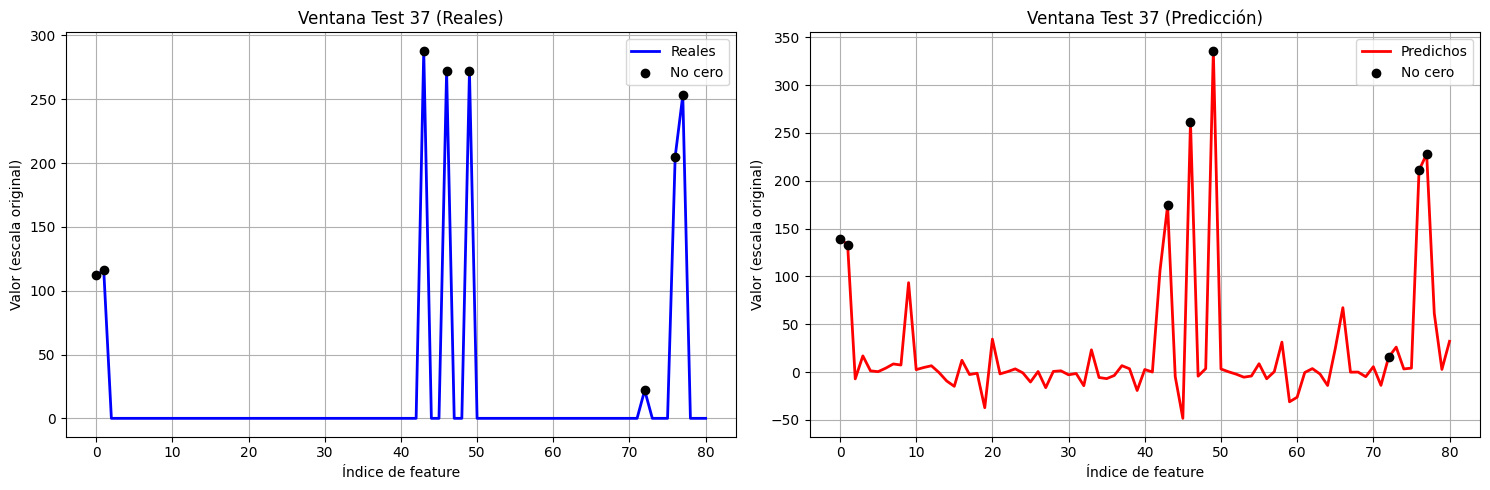

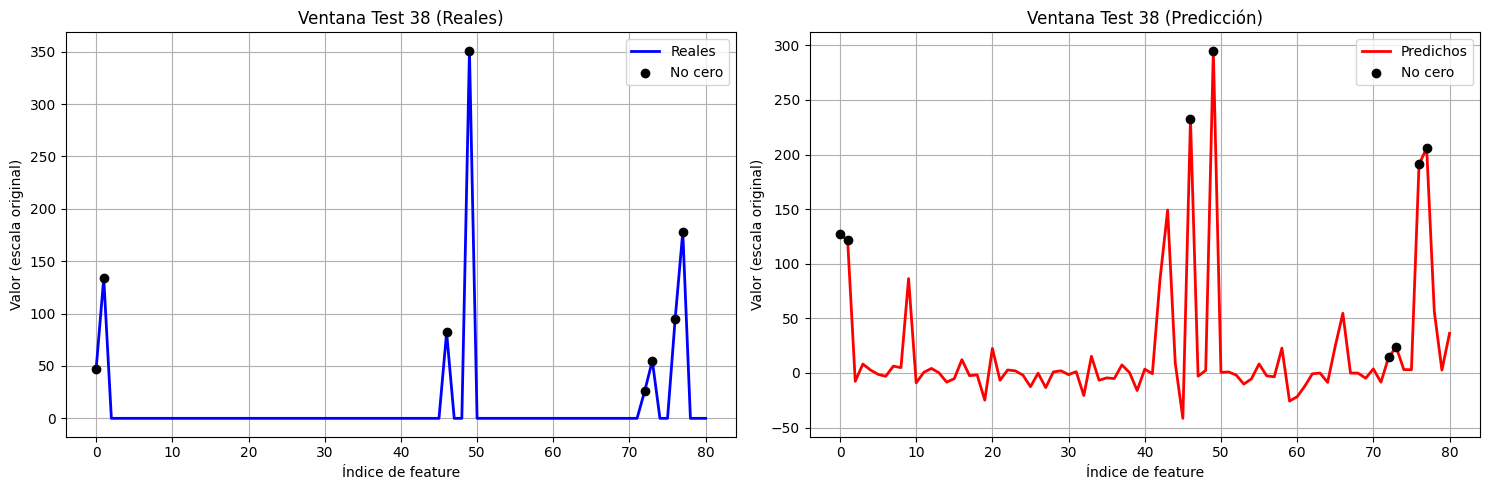

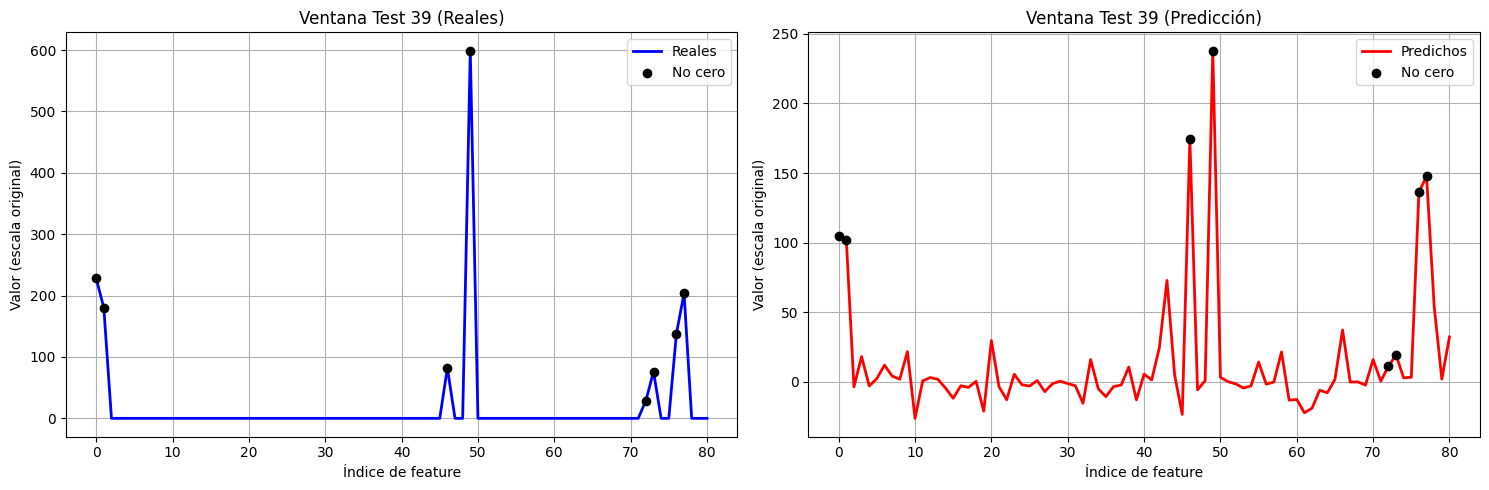

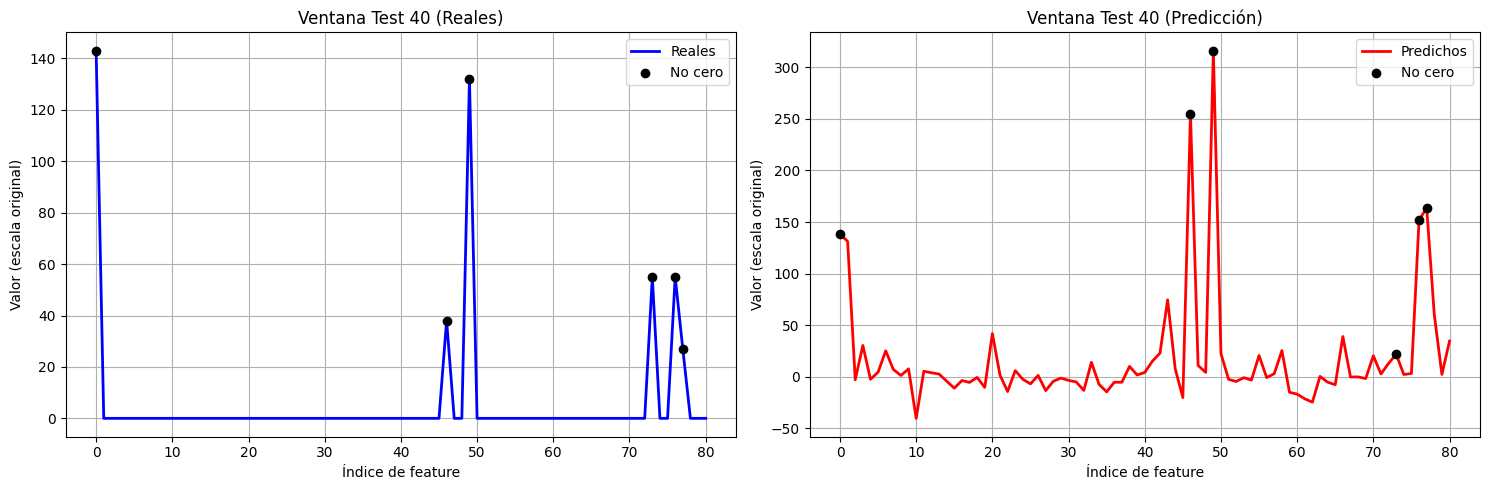

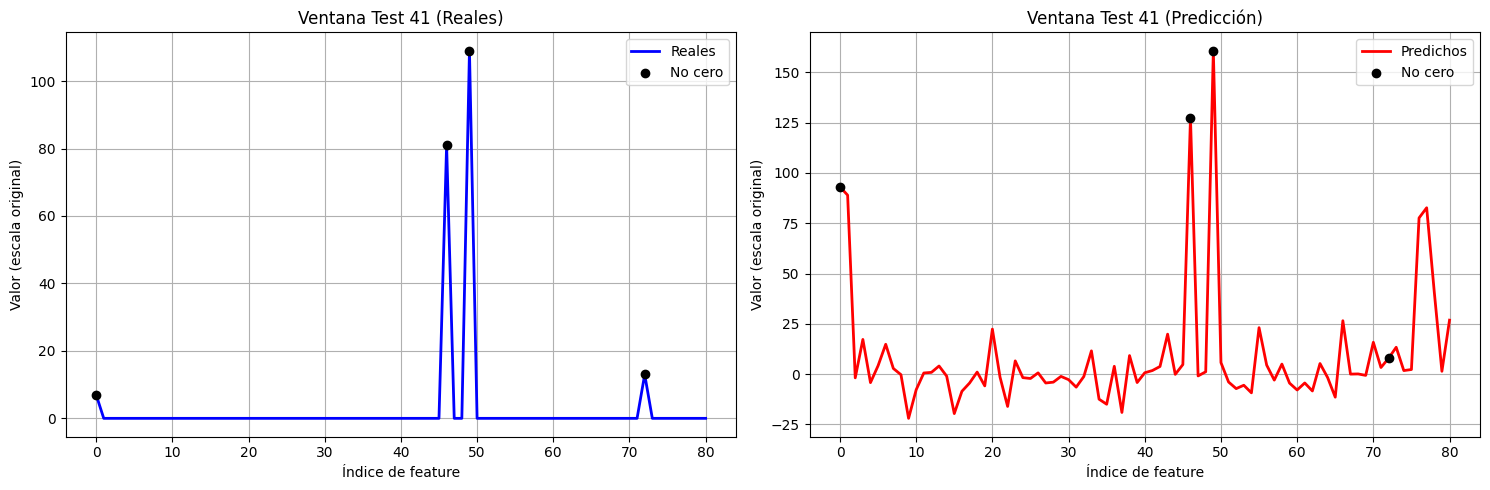

In [27]:
from torch.utils.data import Subset, DataLoader
import numpy as np

model.load_state_dict(torch.load("Mejor_modelo_graphwavenet.pth"))
model.eval()

test_size = len(test_dataset)
last_5_indices = list(range(test_size - 5, test_size))
last_5_subset = Subset(test_dataset, last_5_indices)
last_5_loader = DataLoader(last_5_subset, batch_size=5, shuffle=False)

nodo_idx = 141  # nodo a graficar
predictions_original = []
true_values_original = []

with torch.no_grad():
    for x_norm, A_norm, y_norm in last_5_loader:
        x_norm, A_norm, y_norm = x_norm.to(device), A_norm.to(device), y_norm.to(device)
        y_pred_norm = model(x_norm, A_norm)  # (5, 146, 1, 81)

        # Desnormaliza
        output_min_dev = output_min.to(device)
        output_max_dev = output_max.to(device)
        y_pred = y_pred_norm * (output_max_dev - output_min_dev) + output_min_dev
        y_real = y_norm      * (output_max_dev - output_min_dev) + output_min_dev

        predictions_original.append(y_pred.cpu())
        true_values_original.append(y_real.cpu())

predictions_original = torch.cat(predictions_original, dim=0)  # (5, num_nodes, 1, 81)
true_values_original = torch.cat(true_values_original, dim=0)  # (5, num_nodes, 1, 81)

pred_node = predictions_original[:, nodo_idx, 0, :]  # (5, 81)
true_node = true_values_original[:, nodo_idx, 0, :]  # (5, 81)

for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # REALES
    ax1.plot(true_node[i].numpy(), 'b-', label='Reales', linewidth=2)
    non_zero_idx = np.where(true_node[i].numpy() != 0)[0]
    ax1.scatter(non_zero_idx, true_node[i][non_zero_idx].numpy(),
                color='black', label='No cero', zorder=5)
    ax1.set_title(f"Ventana Test {test_size - 5 + i} (Reales)")
    ax1.set_xlabel("Índice de feature")
    ax1.set_ylabel("Valor (escala original)")
    ax1.grid(True)
    ax1.legend()

    # PREDICHOS
    ax2.plot(pred_node[i].numpy(), 'r-', label='Predichos', linewidth=2)
    ax2.scatter(non_zero_idx, pred_node[i][non_zero_idx].numpy(),
                color='black', label='No cero', zorder=5)
    ax2.set_title(f"Ventana Test {test_size - 5 + i} (Predicción)")
    ax2.set_xlabel("Índice de feature")
    ax2.set_ylabel("Valor (escala original)")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()
    plt.close()
